- #### The data set named Online Retail II includes the online sales activities of a UK-based retail company between 01/12/2009 and 09/12/2011. The product catalog includes souvenir products and it is known that many customers are wholesalers.

| Variable | Definition |
| :- | -: |
| InvoiceNo | Invoice Number (if this code starts with C, it means that order has been canceled) |
| StockCode | Product Code |
| Description | Product Name |
| Quantity | Product Number (how many of the products on the invoices were sold) |
| InvoiceDate | Invoice Date |
| UnitPrice | Invoice Price (pound)|
| CustomerID | Unique Customer Number |
| Country | Country Name |

In [1]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [2]:
import seaborn as sns
import numpy as np
import warnings

In [3]:
pd.set_option ('display.max_columns', 50)
pd.set_option ('display.max_rows', 50)
pd.set_option ('display.float_format', lambda x: '%.2f' % x)
pd.set_option ('display.width', 1000)
warnings.filterwarnings ("ignore")

In [4]:
df = pd.read_excel("online_retail_II-230817-120704.xlsx",
                   sheet_name = "Year 2009-2010")

In [5]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


- **525461 Rows**
- **8 Variables**

In [6]:
df.shape

(525461, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [8]:
df.describe([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,min,1%,10%,25%,50%,75%,90%,95%,99%,max,std
Quantity,525461.00,10.34,-9600.00,-3.00,1.00,1.00,3.00,10.00,24.00,30.00,120.00,19152.00,107.42
InvoiceDate,525461,2010-06-28 11:37:36.845017856,2009-12-01 07:45:00,2009-12-02 14:36:00,2010-01-12 09:48:00,2010-03-21 12:20:00,2010-07-06 09:51:00,2010-10-15 12:45:00,2010-11-19 13:06:00,2010-11-29 15:18:00,2010-12-08 10:40:00,2010-12-09 20:01:00,NaN
Price,525461.00,4.69,-53594.36,0.21,0.65,1.25,2.10,4.21,7.95,10.17,19.95,25111.09,146.13
Customer ID,417534.00,15360.65,12346.00,12435.00,13042.00,13983.00,15311.00,16799.00,17706.00,17913.00,18196.00,18287.00,1680.81


- #### **Quantity and Price variables have negative values.**
- #### **There is a large difference in product quantities and prices between the minimum values and the 1% sample.** 
- #### **A large value difference was observed between 99% of the sample and max values of the same variables.**
- #### **These situations are suspicious about outliers or some data pattnerns.**

In [9]:
df.isnull().sum().sort_values(ascending = False)

Customer ID    107927
Description      2928
Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64

- #### **Orders starting with C on invoices are canceled orders. Let's remove these from the data set.**

In [10]:
df = df[~df["Invoice"].str.contains ("C", na=False)]

- #### **We have seen that the quantity variable contains negative values and has an effect in wide ranges. Therefore, let's set the amount to be greater than zero.**

In [11]:
df = df[(df["Quantity"] > 0)]

- #### **We saw missing values. The missing values here are unique customer numbers, the methods to access or fill them do not make much sense because we can't know what those values are. It's better to drop that values.**

In [12]:
df.dropna(inplace = True)

- #### **We made some adjustment so let's look again at descriptive statistics metrics.**

In [13]:
df.describe([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,min,1%,10%,25%,50%,75%,90%,95%,99%,max,std
Quantity,407695.00,13.59,1.00,1.00,1.00,2.00,5.00,12.00,24.00,36.00,144.00,19152.00,96.84
InvoiceDate,407695,2010-07-01 10:10:10.782177792,2009-12-01 07:45:00,2009-12-02 15:10:00,2010-01-19 11:01:00,2010-03-26 14:01:00,2010-07-09 15:46:00,2010-10-14 17:09:00,2010-11-18 10:37:00,2010-11-28 13:53:00,2010-12-07 14:31:00,2010-12-09 20:01:00,NaN
Price,407695.00,3.29,0.00,0.29,0.65,1.25,1.95,3.75,6.75,8.50,14.95,10953.50,34.76
Customer ID,407695.00,15368.50,12346.00,12435.00,13044.00,13997.00,15321.00,16812.00,17706.00,17913.00,18196.00,18287.00,1679.80


- #### **The minimum value in the Price variable has been updated to 0. I don't think anything is being sold for free, but there is an improvement here, but the suspicious situation continues in this view.**

- #### **The minimum value in the Quantity values has been updated to 1.Looks like proper.**

- #### **The lower points in the Quantity and Price variables are balanced appropriately, but the gap between the 99% and maximum values at the upper points still continues.**

- #### **Let's look at 0 priced rows and try to get their product codes.**

In [14]:
df[df["Price"] == 0]["StockCode"].unique()

array([22076, 48185, 'M', 22065, 22142, 85042, 21143, 79320, 22355, 21533,
       'TEST001', 21662, 22459, 22458, 22376, 21765, 20914, 22423, 22690,
       22472, 22202, '46000M', 22218, 22630, 22121, 21843, 22624, 22846,
       22845, 22841], dtype=object)

- #### The structure of product codes progresses numerically.
- #### 'M', 'TEST001', '46000M' codes are suspicious inputs.
- #### We don't know what these codes are. Also, we don't know any business insights so imputation methods are not usable so dropping them seems proper.

In [15]:
df = df[df["StockCode"] != "M"]

- #### Dropped rows which are containing letter M but we saw that there are some values with more letter codes.Let's check them.

In [16]:
invalid_codes = df[df["StockCode"].astype(str).str.contains(r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()

In [17]:
invalid_codes

['POST', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'ADJUST2']

- #### So we have not just M letter codes we have many more but what is the sample size for these?

In [18]:
df[df["StockCode"].isin(invalid_codes)].groupby(["StockCode"]).agg({"Invoice": "nunique",
                                                                       "Quantity": "sum",
                                                                       "Price": "sum",
                                                                       "Customer ID": "nunique"})

,Invoice,Quantity,Price,Customer ID
StockCode,,,,
ADJUST,32,32,3538.52,25
ADJUST2,3,3,731.05,3
BANK CHARGES,20,20,300.00,12
PADS,14,14,0.01,12
POST,738,2212,19964.83,230
TEST001,11,60,40.50,4
TEST002,1,1,1.00,1


- #### POST code has max sample but it's still low amount of sample.
- #### For example, TEST002 stock code appeared in just one row.
- #### Even if we sum up all invoices, it is not passing 1000 invoces or 500 customerssince there are 500000 observations and it is not possible to fill or modify them because we do not have any business information. Looks like dropping is proper solution.

In [19]:
df = df[~df["StockCode"].isin(invalid_codes)].reset_index(drop=True)

- POST stock code has high prices.
- Wanted to check decriptive statistic metrics.

In [20]:
df.describe([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,min,1%,10%,25%,50%,75%,90%,95%,99%,max,std
Quantity,406450.00,13.62,1.00,1.00,1.00,2.00,5.00,12.00,24.00,36.00,144.00,19152.00,96.99
InvoiceDate,406450,2010-07-01 10:28:27.142084608,2009-12-01 07:45:00,2009-12-02 15:04:00,2010-01-19 10:41:00,2010-03-26 14:01:00,2010-07-09 15:48:00,2010-10-14 17:09:00,2010-11-18 10:37:00,2010-11-28 13:51:00,2010-12-07 14:31:00,2010-12-09 20:01:00,NaN
Price,406450.00,3.01,0.00,0.29,0.65,1.25,1.95,3.75,6.75,8.50,12.75,295.00,4.37
Customer ID,406450.00,15373.48,12346.00,12437.00,13050.00,14006.00,15325.00,16814.00,17706.00,17913.00,18196.00,18287.00,1677.23


- #### We saw proper recovery for min values.
- #### In max values, there is a decrease for the values, but between 99% and max the clarity is still open enough to be suspicious.

- #### Let's try to evaluate this suspicious openness by reducing this structure a little more..

- #### We can do this reducing part with RFM. For this we need to adjust columns which are,
- #### Recency: Today - Last Shopping Day
- #### Frequency: Shopping Frequency
- #### Monetary: Money Amount

- #### We have product price for each product and bought quantity so we can multiply them for total amount.

In [21]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [22]:
df.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99]).T

,count,mean,min,1%,10%,25%,50%,75%,90%,99%,max,std
Quantity,406450.00,13.62,1.00,1.00,1.00,2.00,5.00,12.00,24.00,144.00,19152.00,96.99
InvoiceDate,406450,2010-07-01 10:28:27.142084608,2009-12-01 07:45:00,2009-12-02 15:04:00,2010-01-19 10:41:00,2010-03-26 14:01:00,2010-07-09 15:48:00,2010-10-14 17:09:00,2010-11-18 10:37:00,2010-12-07 14:31:00,2010-12-09 20:01:00,NaN
Price,406450.00,3.01,0.00,0.29,0.65,1.25,1.95,3.75,6.75,12.75,295.00,4.37
Customer ID,406450.00,15373.48,12346.00,12437.00,13050.00,14006.00,15325.00,16814.00,17706.00,18196.00,18287.00,1677.23
TotalPrice,406450.00,21.36,0.00,0.65,2.10,4.95,11.85,19.50,35.40,197.10,15818.40,69.14


- #### To find the last shopping date, we find the maximum value of billing times.

In [23]:
max_invoice_date = df["InvoiceDate"].max()

In [24]:
max_invoice_date

Timestamp('2010-12-09 20:01:00')

- #### From here, we need to move on to how recently customers shopped. 
- #### After finding this, using this max value may show some values as 0. To solve this situation, we can start this difference from 1 or 2 by putting a difference of 1 or 2 days.

In [25]:
today_date = (max_invoice_date + dt.timedelta(days=2))

In [26]:
today_date

Timestamp('2010-12-11 20:01:00')

- #### We can extract these values with grouping unique customer numbers.

In [27]:
rfm = df.groupby("Customer ID").agg({"InvoiceDate": lambda date: (today_date - date.max()).days,
                                       "Invoice": "nunique",
                                       "TotalPrice": "sum"})

In [28]:
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


In [29]:
rfm.shape

(4286, 3)

- #### Sütun isimlerini RFM yapısına uygun hale getirelim.

In [30]:
rfm.columns = ["Recency", "Frequency", "Monetary"]

In [31]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


- #### In this way, we solved the problem that the last shopping day had a value of 0.
- #### Should adjust some configuration for Frequency and Monetary.

In [32]:
rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]

- #### Wanted to check decriptive statistics metrics again after this configs.

In [33]:
rfm.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Recency,4286.00,91.56,96.35,2.00,2.00,9.00,19.00,53.00,136.75,255.00,369.00,375.00
Frequency,4286.00,4.43,7.95,1.00,1.00,1.00,1.00,2.00,5.00,9.00,31.15,184.00
Monetary,4286.00,2025.18,8829.91,1.55,40.76,157.03,307.66,702.25,1703.98,3761.56,19749.29,349164.35


- #### No 0 values in Recency min metrics.
- #### No 0 values or any looking like outlier values in min metric of Frequency.
- #### In %99 between max points of dataset we have outliers in Monetary and Frequency.

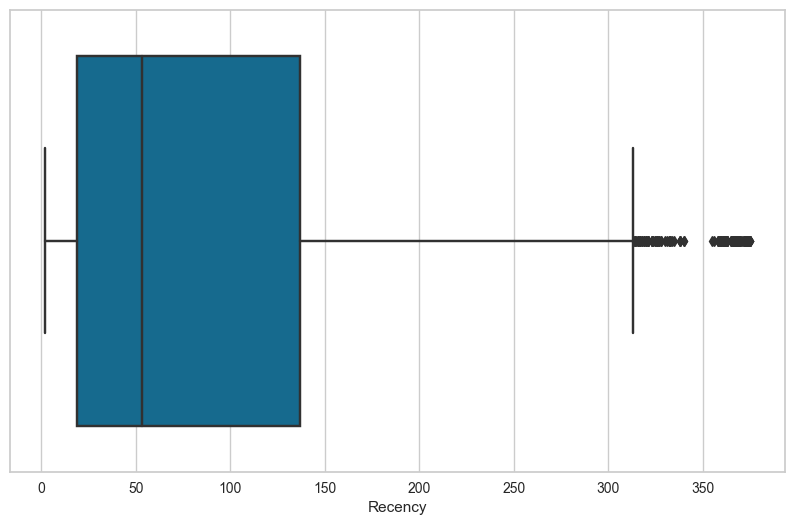

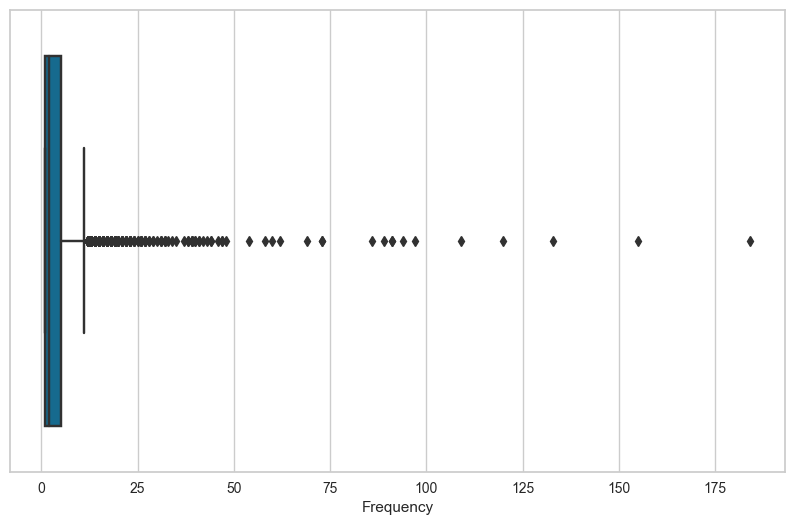

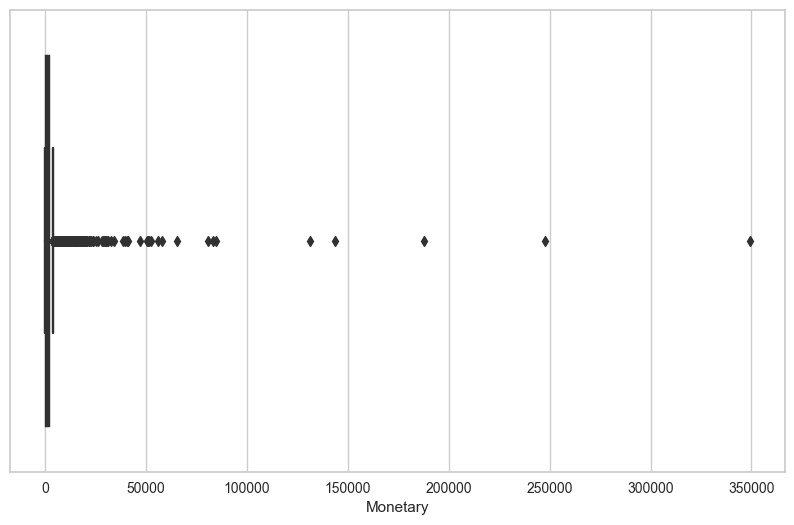

In [34]:
for col in rfm.columns:
    plt.figure(figsize = (10, 6))
    sns.boxplot(x = rfm[col])
    plt.show()

In [35]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile (q1)
    quartile3 = dataframe[col_name].quantile (q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [36]:
for col in rfm.columns:
    print(col, outlier_thresholds(rfm, col))

Recency (-444.5, 751.5)
Frequency (-17.0, 31.0)
Monetary (-8968.220000000001, 15243.2)


In [37]:
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds (dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any (axis=None):
        return True
    else:
        return False

In [38]:
for col in rfm.columns:
    print(col, check_outlier(rfm, col))

Recency False
Frequency True
Monetary True


- #### Recency variable has outliers but it can not be seen in %5 - %95 parts of data. For not changing dataset patterns we are looking in that range if we go up for more we may change decriptive metrics and it is going to change distribution of data. This is not a situation we want.

- #### Now we can trim these values at %5-%95 range.

In [39]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds (dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [40]:
for col in rfm.columns:
    replace_with_thresholds(rfm, col)

- #### Checking decriptive statistics metrics.

In [41]:
rfm.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Recency,4286.00,91.56,96.35,2.00,2.00,9.00,19.00,53.00,136.75,255.00,369.00,375.00
Frequency,4286.00,4.11,4.89,1.00,1.00,1.00,1.00,2.00,5.00,9.00,31.00,31.00
Monetary,4286.00,1588.58,2523.16,1.55,40.76,157.03,307.66,702.25,1703.98,3761.56,15243.20,15243.20


- #### Seems like, suspicious %99-max range of dataset values has been solved.
- #### The suspicious structure for the Monetary variable has also been largely corrected.
- #### For the Monetary variable, the maximum value, which was around 300,000 before the outlier observation compensation, was reduced to around 15,000.

- #### Checking distribution of these variables.

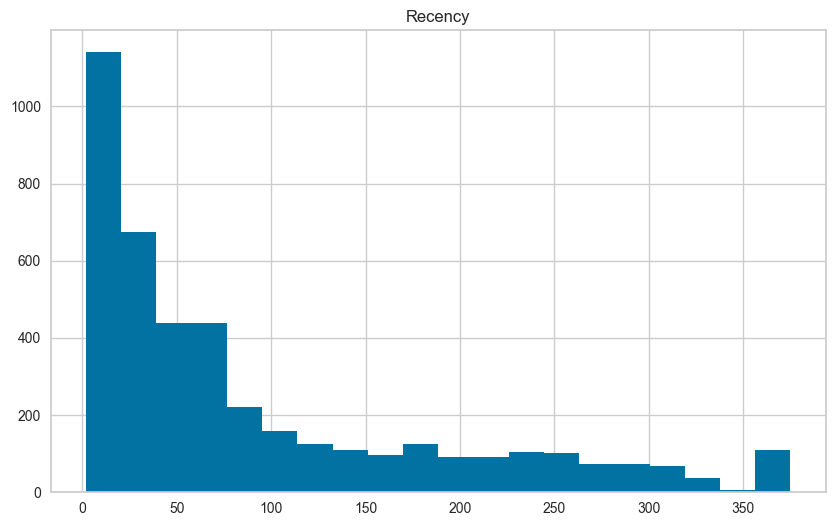

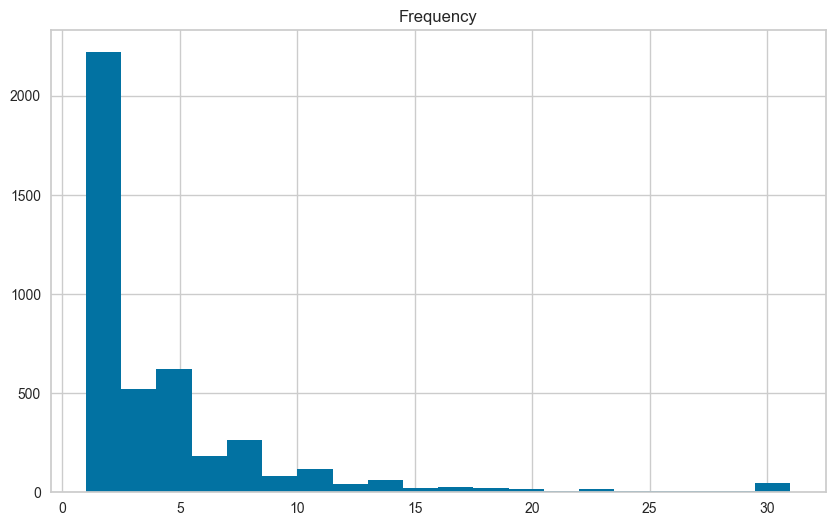

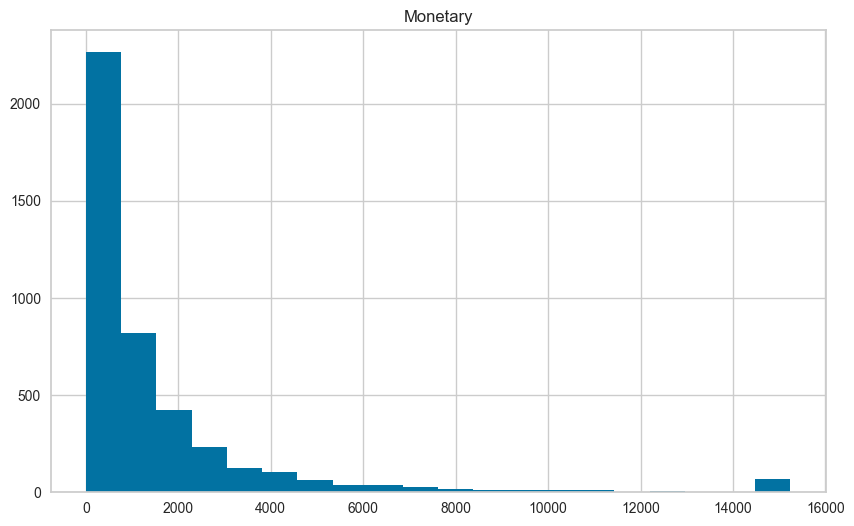

In [42]:
for col in rfm.columns:
    plt.figure(figsize = (10, 6))

    rfm[col].hist(bins=20)
    
    plt.title(f"{col}")
    plt.show()

- #### All variables have right skewed distribution. We want our variables to be close to normal distribution. The reason for this is to disseminate the observations and transform them into a form that can be expressed more easily. 
- #### For these purposes we can use Log Transformation.
- #### Monetary variable can stay like this because we won't use it in any algorithm. It is just for comparison.

In [43]:
for col in ["Recency", "Frequency"]:
    rfm[f"LOG_{col}"] = np.log1p(rfm[col])

In [44]:
rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency
Customer ID,,,,,
12346.00,166.00,2,169.36,5.12,1.10
12347.00,4.00,2,1323.32,1.61,1.10
12348.00,75.00,1,221.16,4.33,0.69
12349.00,44.00,2,2221.14,3.81,1.10
12351.00,12.00,1,300.93,2.56,0.69


- #### For easiness of evaluation, variables must be aligned in the same scale.

In [45]:
scaler = StandardScaler()

In [46]:
scaler.fit(rfm[["LOG_Recency", "LOG_Frequency"]])

StandardScaler()

In [47]:
scaled_rf = scaler.transform(rfm[["LOG_Recency", "LOG_Frequency"]])

- #### After scaling processes, output is turning numpy array format so we need to turn back the DataFrame structure.

In [48]:
scaled_df = pd.DataFrame (index=rfm.index, columns=["LOG_Recency", "LOG_Frequency"], data=scaled_rf)

In [49]:
scaled_df.head()

,LOG_Recency,LOG_Frequency
Customer ID,,
12346.00,0.99,-0.40
12347.00,-1.85,-0.40
12348.00,0.35,-1.00
12349.00,-0.07,-0.40
12351.00,-1.08,-1.00


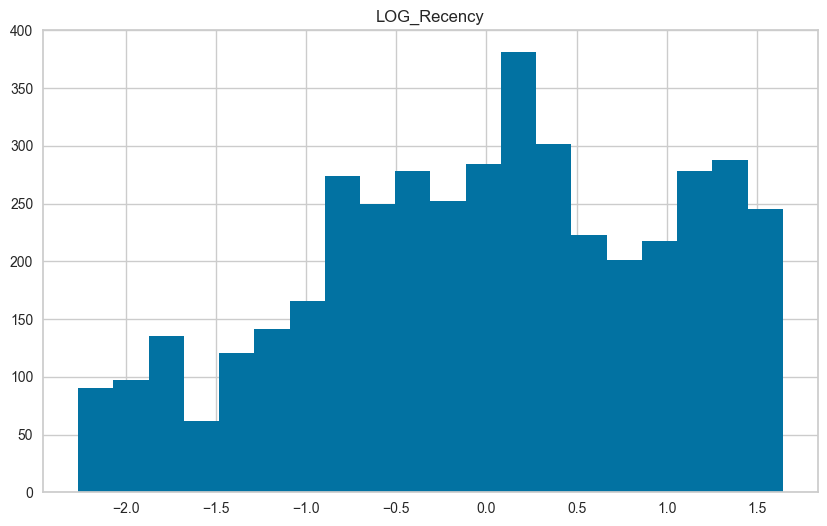

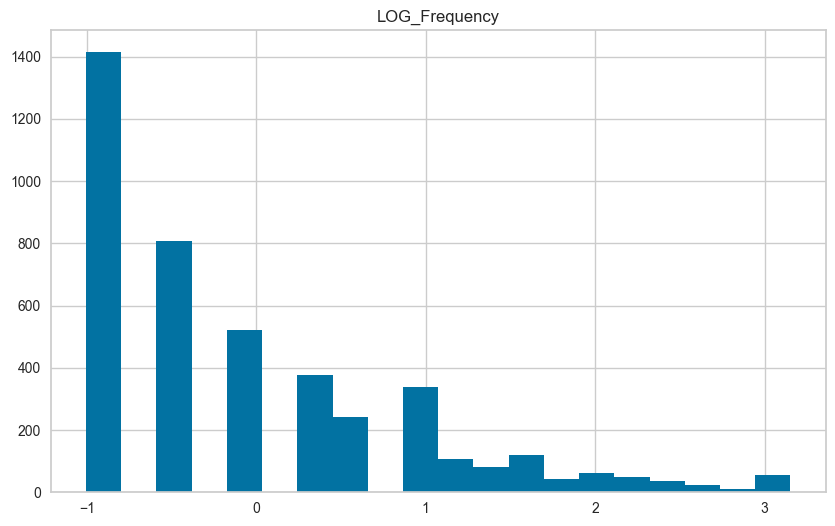

In [50]:
for col in scaled_df.columns:
    plt.figure(figsize = (10, 6))

    scaled_df[col].hist(bins=20)
    
    plt.title(f"{col}")
    plt.show()

- #### It is impossible to completely normalize the distribution but with this way we can spread and reduce skewness in variables.

- #### Utilized from KMeans for customer segmentation. 

In [51]:
kmeans = KMeans()

- #### Used Elbow method for optimizing cluster numbers.

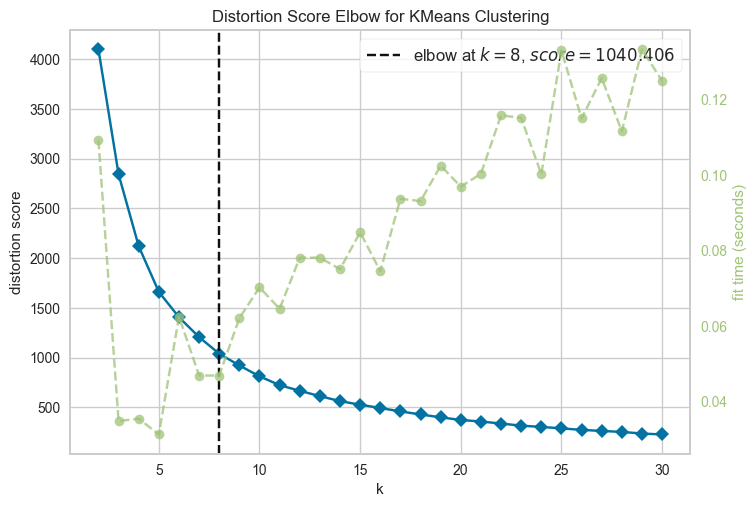

In [52]:
elbow = KElbowVisualizer(kmeans, k=30)

elbow.fit(scaled_df)

elbow.show();

- #### The lowest distance error was seen in the 8-cluster structure with sum of squares.

In [53]:
k = elbow.elbow_value_

In [54]:
k

8

In [55]:
k_means = KMeans(n_clusters= k, random_state=99).fit(scaled_df)

In [56]:
segments = k_means.labels_

- #### Transferred segments in RFM structure.

In [57]:
rfm["KMeans_Segments"] = segments

In [58]:
rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency,KMeans_Segments
Customer ID,,,,,,
12346.00,166.00,2,169.36,5.12,1.10,1
12347.00,4.00,2,1323.32,1.61,1.10,0
12348.00,75.00,1,221.16,4.33,0.69,2
12349.00,44.00,2,2221.14,3.81,1.10,2
12351.00,12.00,1,300.93,2.56,0.69,6


- #### We can group these segments by Recency, Frequency and Monetary. With this way, we can evaluate segments. 
- #### We can make this evaluation based on the Monetary variable because we did not use this variable in the KMeans algorithm, but this alone will not be enough. That's why we need to evaluate with Recency ve Frequency.

In [59]:
rfm.groupby("KMeans_Segments").agg({"Recency": ["mean", "median", "count"],
                                      "Frequency": ["mean", "median", "count"],
                                      "Monetary": ["mean", "median", "count"]})

Recency              Frequency              Monetary              
                   mean median count      mean median count     mean  median count
KMeans_Segments                                                                   
0                  6.39   5.00   352      5.23   5.00   352  1896.92 1382.80   352
1                241.97 234.00   939      1.24   1.00   939   403.23  266.50   939
2                 69.27  66.00   790      1.43   1.00   790   533.50  378.46   790
3                 32.65  25.00   384     10.40   9.00   384  4145.36 3148.78   384
4                  6.02   5.00   214     19.23  17.00   214  7843.35 6008.61   214
5                118.37  96.00   578      4.17   4.00   578  1667.55 1234.72   578
6                 20.11  20.00   474      1.47   1.00   474   506.44  350.01   474
7                 29.66  29.00   555      4.08   4.00   555  1561.51 1189.38   555

- #### For example, the Monetary structures of the 5th segment and the 7th segment have similar average, median and observation values. There may be a thought as to whether these should be combined.
- #### As we continue to observe these segments, Frequency structures also show similar metrics..
- #### However, the shopping frequency structure (Recency) of these customers is different and these clusters are separated at this point. The 5th segment is based on old customers, but the 7th segment has newer customers.

- #### The segment with the highest money spending is seen as the 4th segment. There may be special campaigns for this segment.
- #### Similarly, the segment with the lowest spending is segment 1 and these customers have not made any purchases recently. Their frequencies also have the lowest values. There may be special campaigns for these customers.

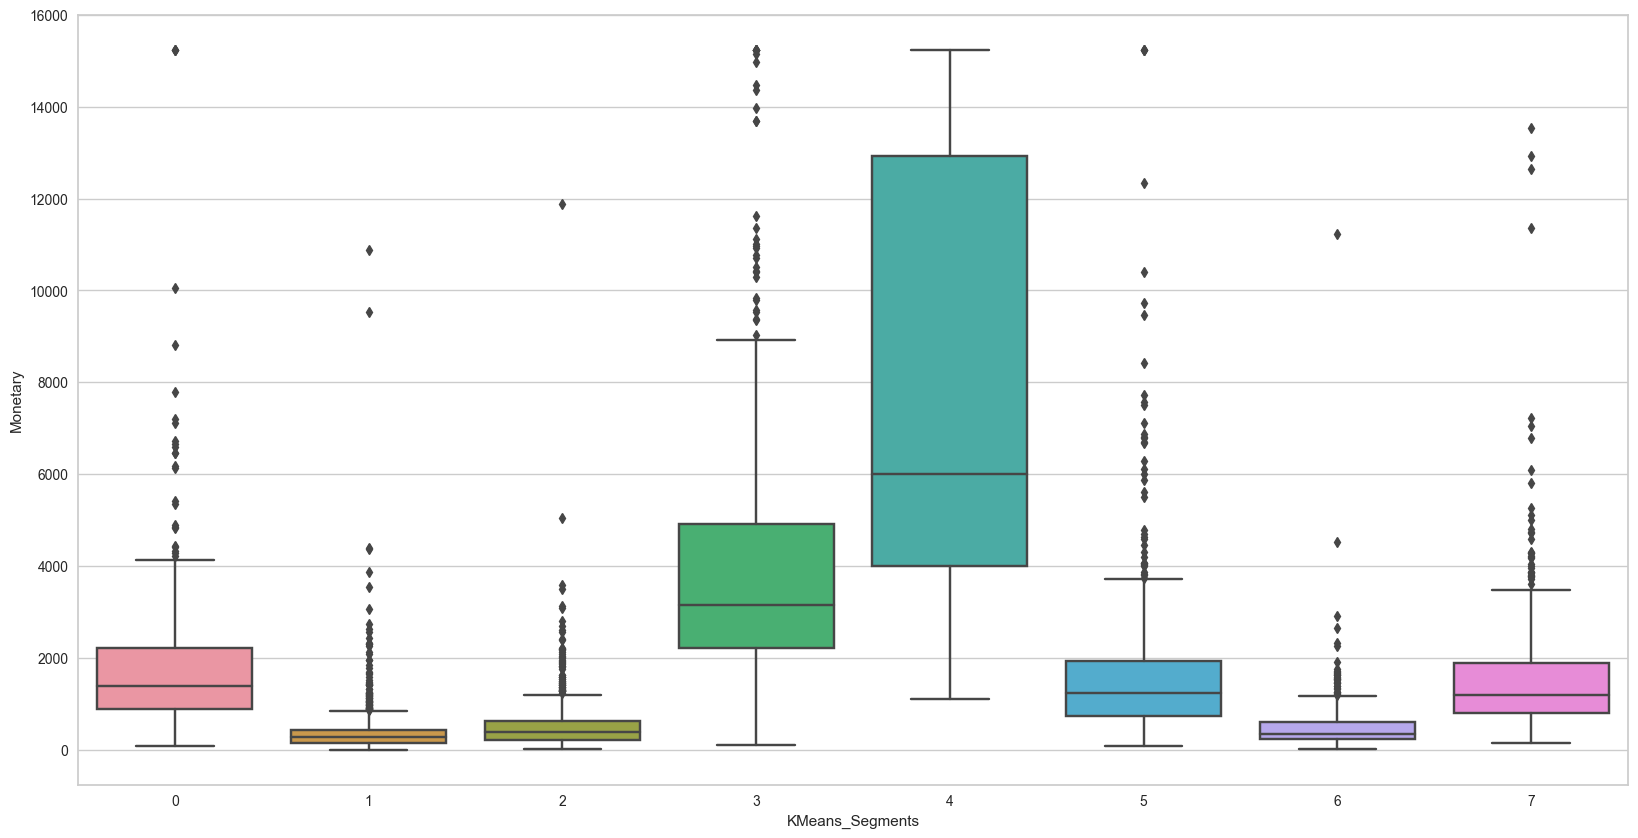

In [60]:
plt.figure(figsize=(20, 10))

sns.boxplot(x="KMeans_Segments", y="Monetary", data=rfm)

plt.show()

- #### With visualization, observed that segments 1, 2 and 6 have close patterns with each other.
- #### But this comment was based on the Monetary variable, which is our metric. For this reason, need to evaluate it according to our Frequency and Recency variables.
- #### They have similar Frequency structures, but the point where these segments differ is the Recency structure.

- #### Let's examine this situation with the hierarchical clustering method.
- #### Created the hierarchical clustering structure in a unifying way from the general to the specific and increase the number of clusters to 10.

In [61]:
hc = linkage(scaled_df, 'complete')

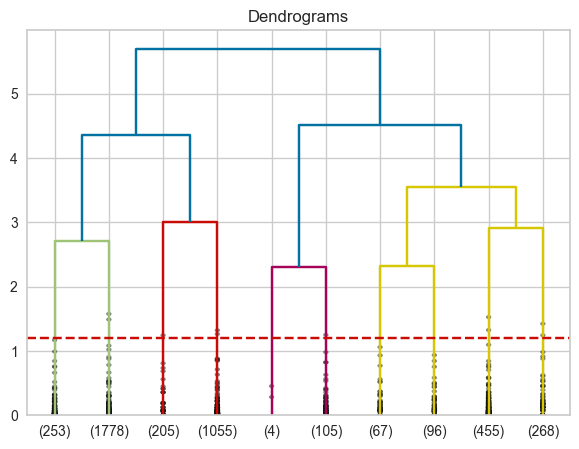

In [62]:
plt.figure(figsize=(7, 5))

plt.title("Dendrograms")

dend = dendrogram(hc,
                   truncate_mode="lastp",
                   p=10,
                   show_contracted=True,
                   leaf_font_size=10)

plt.axhline(y=1.2, color='r', linestyle='--')

plt.show()

- #### Among the 10 classes, the 4 yellow classes can be combined and reduced to 6 classes.

In [63]:
hc_ = AgglomerativeClustering(n_clusters=6)

In [64]:
segments = hc_.fit_predict(scaled_df)

In [65]:
rfm["Hierarchical_Segments"] = segments

- #### Checking general structure

In [66]:
rfm.groupby("Hierarchical_Segments").agg({"Recency": ["mean", "median", "count"],
                                         "Frequency": ["mean", "median", "count"],
                                         "Monetary": ["mean", "median", "count"]})

Recency              Frequency              Monetary              
                         mean median count      mean median count     mean  median count
Hierarchical_Segments                                                                   
0                       22.54  17.00   915      8.22   7.00   915  3183.45 2342.57   915
1                       71.59  60.00  1091      3.42   3.00  1091  1354.29  940.86  1091
2                      227.53 220.00  1131      1.43   1.00  1131   474.46  301.65  1131
3                       13.24  13.00   462      2.05   2.00   462   654.60  498.73   462
4                       55.18  53.50   534      1.00   1.00   534   413.07  281.32   534
5                        5.11   5.00   153     21.38  19.00   153  8880.06 7637.56   153

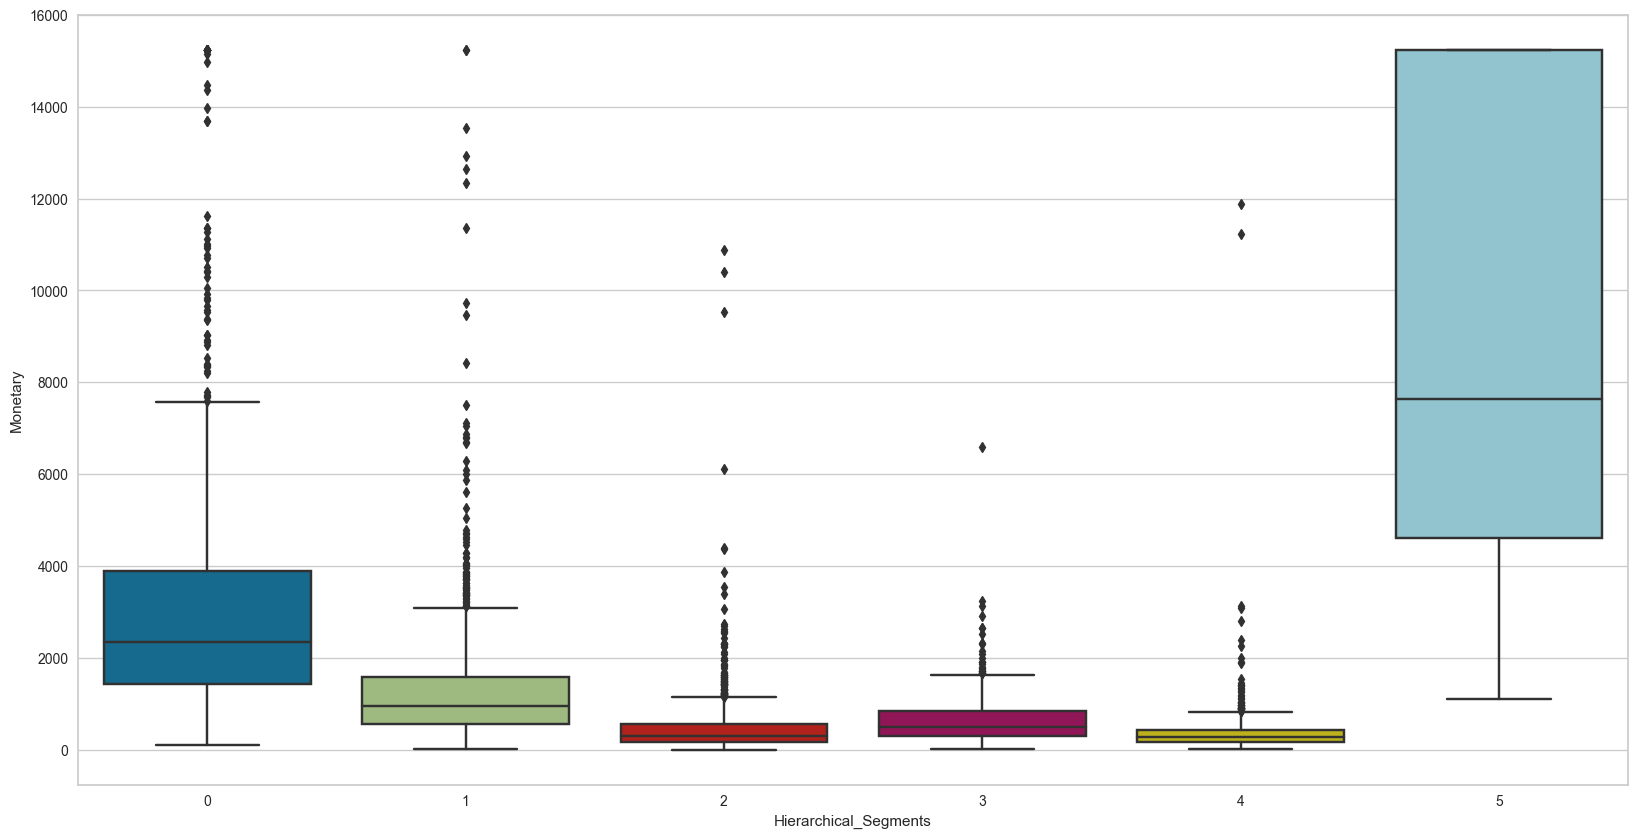

In [67]:
plt.figure (figsize=(20, 10))

sns.boxplot(x="Hierarchical_Segments", y="Monetary", data=rfm)

plt.show()

- #### Classes 2 and 4 are very similar in terms of the amount of money spent. Is it possible to combine these classes? Let's check.

- #### They have similar Monetary and Frequency values, but they differ in terms of when the customers last shopped. The shopping made by class 2 can be classified as very old and even we can make this class lost, but class 4 is much more recent.

- #### Class 5 is very valuable. Max. value for money is in this class. Customers shopped very frequently and made purchases very recently.
- #### As an important point, the least number of customers is in the 5th grade.

- #### Most customers are in the 2nd class, but mentioned that this customer class can be classified as lost. Efforts can be made to keep these customers up to date.